## SAGA Paper 4, FIGURE 4:  Quenched fractions

In [1]:
import numpy as np
import os
from myplotstyle import plt,get_figsize

%matplotlib inline

import pandas as pd
from scipy import stats
import matplotlib.lines as mlines

import matplotlib
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from astropy.io import ascii
from astropy.table import Table
from scipy.stats import norm


In [2]:
saga = SAGA.QuickStart()
hosts = saga.host_catalog.load(include_stats=True, query="paper3")

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)
sats_maybe_all = Query(~C.has_spec, "p_sat_corrected > 0", C.sat_rcut).filter(base)

In [4]:
pbins = np.linspace(0, 100, 8)
log_sm = np.concatenate([sats['log_sm']])
log_sm = log_sm[log_sm >= 6.75]
bins = np.percentile(log_sm, pbins)
x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

In [5]:
def calc_fq(count_q, count_sf):
    fq = count_q / (count_sf + count_q)
    fq_bias_corrected =  (count_q + 1) / (count_sf + count_q + 2)
    fq_err = np.sqrt(fq_bias_corrected * (1 - fq_bias_corrected) / (count_sf + count_q))
    return fq, fq_err


In [6]:
# ELVES
elves_file = 'data/compiled_elves_data.csv'

In [7]:
elves_df = pd.read_csv(elves_file)
nhost_elves = len(elves_df.groupby('HOST').groups.keys())

# LOAD GRAND LIST
grand_list = saga.host_catalog.load_master_list()

# MAKE LIST OF 28 ELVES HOST NAMES
elves_host_list = elves_df.Name_Host.value_counts().keys()

# ACCOUNTING FOR ELVES HOSTS THAT HAVE DIFF NAMES IN GRAND LIST
elves_name_dict = {'CENA'  :'NGC5128',
                   'M104'  :'NGC4594',
                   'M81'  :'NGC3031',
                   'NGC253'  :'NGC0253',
                   'NGC4517'  :'NGC4437',
                   'NGC628'  :'NGC0628',
                   'NGC891'  :'NGC0891'}
rev_elves_name_dict = { v:k for k,v in elves_name_dict.items()}
# REMAKE LIST OF ELVES HOSTS, NOW SWAPPING IN GRAND LIST NAMES
elves_host_list_grand_list_convention = [elves_name_dict.get(item,item)  for item in elves_host_list]

# DEFINE MINIMAL SAGA HOST CUTS (ENV + STELLAR MASS CUTS)
min_cuts = Query(
    "BRIGHTEST_K_R1 >= K_TC + 1.6",
    "M_HALO < 13",
    "K_ABS >= -24.6",
    "K_ABS <= -23.0"
)

# APPLY CUTS TO GRAND LIST
min_cuts_df = min_cuts.filter(grand_list).to_pandas()

# CROSSMATCH ELVES SELECTED GRAND LIST WITH ELVES DF USING ELVES NAMES
elves_min_cuts_list_glc = min_cuts_df[min_cuts_df['COMMON_NAME'].isin(elves_host_list_grand_list_convention)]['COMMON_NAME'].values
elves_min_cuts_list = [rev_elves_name_dict.get(item,item)  for item in elves_min_cuts_list_glc]
elves_min_cuts_df = elves_df[elves_df['HOST'].isin(elves_min_cuts_list)].copy()



In [8]:
elves     = Table.from_pandas(elves_min_cuts_df)
elves_all = Table.read(elves_file)

print('all elves hosts',np.size(np.unique(elves_all['HOST'])))
print('SAGA elves hosts',np.size(np.unique(elves['HOST'])))

all elves hosts 28
SAGA elves hosts 14


In [9]:
elves_q    = elves['quenched'] == 1
elves_sm   = elves['log_sm'] >= 6.5

mask_sf = ~elves_q & elves_sm
mask_q = elves_q & elves_sm

count_sf = np.histogram(elves["log_sm"][mask_sf], bins, weights=elves["Psat"][mask_sf])[0]
count_q = np.histogram(elves["log_sm"][mask_q], bins, weights=elves["Psat"][mask_q])[0]

eqf,eqf_err = calc_fq(count_q, count_sf)

##########
elves_q_all  = elves_all['quenched'] == 1
elves_sm_all = elves_all['log_sm'] >= 6.5

mask_sf_all = ~elves_q_all & elves_sm_all
mask_q_all = elves_q_all & elves_sm_all

count_sf2 = np.histogram(elves_all["log_sm"][mask_sf_all], bins, weights=elves_all["Psat"][mask_sf_all])[0]
count_q2  = np.histogram(elves_all["log_sm"][mask_q_all], bins, weights=elves_all["Psat"][mask_q_all])[0]

eqf2,eqf_err2 = calc_fq(count_q2, count_sf2)

ex = 0.5 * (bins[1:] + bins[:-1])

In [10]:
# MILKY WAY
mw_sm = np.log10([2700e6, 310e6,43e6, 39e6, 9e6])
mw_fq  = [0,0,1,1,1]


In [11]:
def calc_saga_points(sats, sats_maybe_all, bins, color="C2"):

    color_quenched_def = C.color_quenched_def

    n_q = np.histogram(Query('quenched > 0').filter(sats, 'log_sm'), bins)[0]
    sats_q = Query('quenched > 0').filter(sats, ["log_sm", "RHOST_KPC"])
    sats_maybe_q = Query('quenched_phony > 0').filter(sats_maybe_all, ["log_sm_phony", "RHOST_KPC", "p_sat_corrected"])
    n_q_imc = np.histogram(sats_q['log_sm'], bins)[0] + np.histogram(sats_maybe_q['log_sm_phony'], bins, weights=sats_maybe_q["p_sat_corrected"])[0]

    n_all = np.histogram(sats['log_sm'], bins)[0]
    n_all_imc = np.histogram(sats['log_sm'], bins)[0] + np.histogram(sats_maybe_all['log_sm_phony'], bins, weights=sats_maybe_all["p_sat_corrected"])[0]

    p = n_q_imc/n_all_imc
    pb = (n_q_imc+1)/(n_all_imc+2)

    perr = np.sqrt(pb*(1-pb) / n_all_imc)
    p1 = np.minimum(1, p + perr)
    p2 = np.maximum(0, p - perr)

    return p,p1,p2, n_all,n_q*1.0



In [12]:
def host_selection(*query, invert=False):
    return QueryMaker.isin("HOSTID", Query(*query).filter(hosts, "HOSTID"), invert=invert)

In [13]:
# DEFINE LOCAL GROUP HOSTS

h_lg = host_selection("NEARBY_MW_COUNT_1 == 1")

lg_base = h_lg.filter(base)
lg_sats = C.is_sat.filter(lg_base)
lg_sats_maybe_all = Query(~C.has_spec, "p_sat_corrected > 0", C.sat_rcut).filter(lg_base)

lg_p, lg_p1, lg_p2, n_all,n_q = calc_saga_points(lg_sats, lg_sats_maybe_all,bins)

/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_65764/3977718344.py:13: RuntimeWarning: invalid value encountered in true_divide
  p = n_q_imc/n_all_imc
/var/folders/lh/yw50lcqx1135l567zq_g_0crf3vhm2/T/ipykernel_65764/3977718344.py:16: RuntimeWarning: divide by zero encountered in true_divide
  perr = np.sqrt(pb*(1-pb) / n_all_imc)


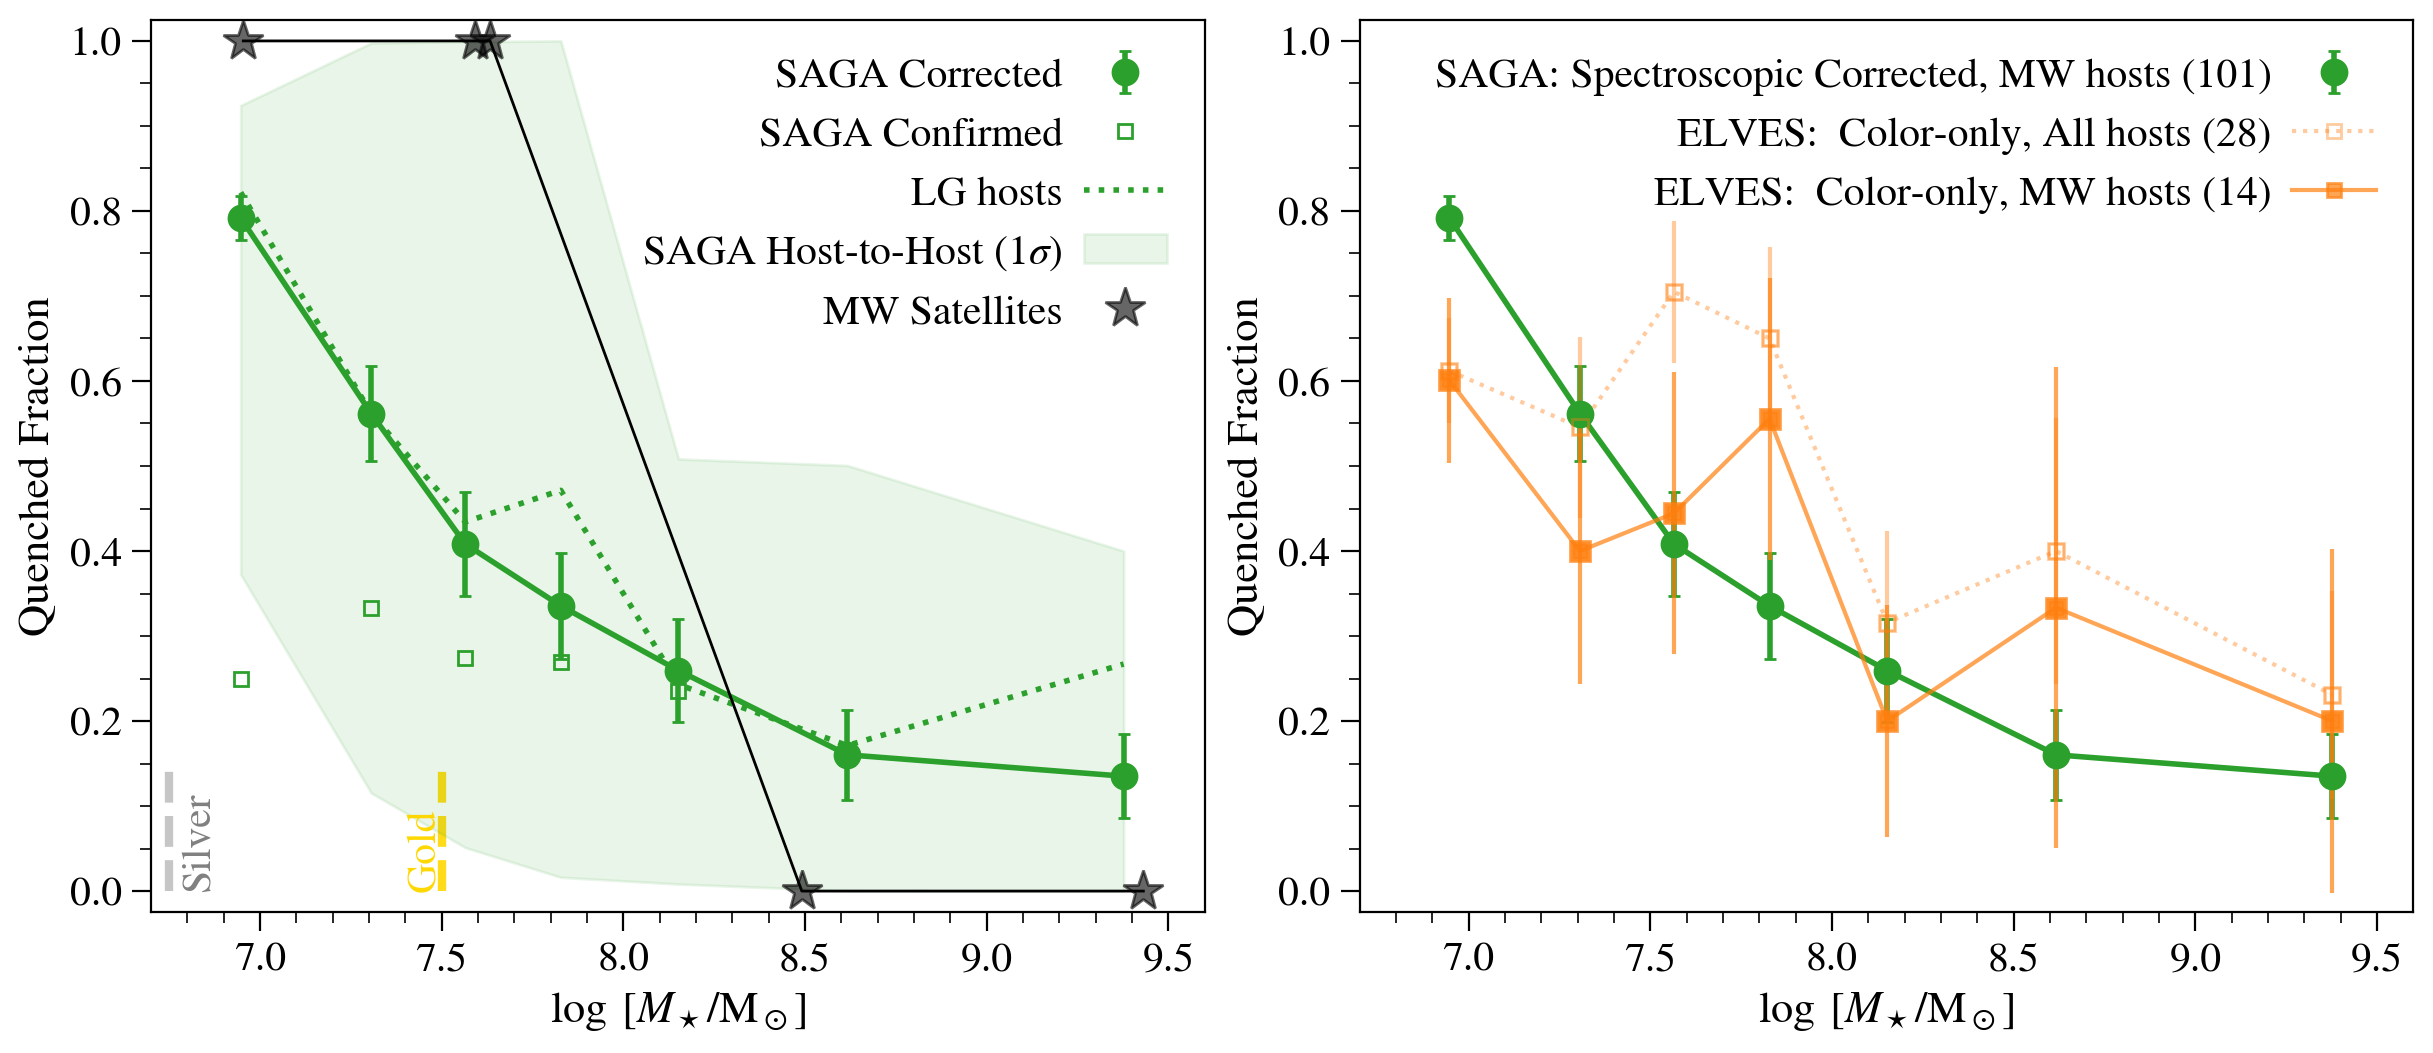

In [14]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_quenched.pdf')


fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=get_figsize(wide=True, ratio=2.4))

pbins = np.linspace(0, 100, 8)
log_sm = np.concatenate([sats['log_sm']])
log_sm = log_sm[log_sm >= 6.75]
bins   = np.percentile(log_sm, pbins)
x      = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

p, p1, p2, n_all,n_q = calc_saga_points(sats, sats_maybe_all,bins)

ax1.errorbar(x, p, yerr=(p-p2, p1-p), ls='', marker='o', lw=2, capsize=2, ms=9, c="C2",label='SAGA Corrected',zorder=1)
ax1.plot(x, n_q/n_all, ls='', marker='s', mfc='none', ms=5, c="C2",label='SAGA Confirmed')
ax1.plot(x, p, 'o',lw=2, c="C2",label='__no__',ls='-')

fq_raw = n_q/n_all

# PLOT LG
#ax1.errorbar(x, lg_p, yerr=(lg_p-lg_p2, lg_p1-lg_p), ls='')
ax1.plot(x,lg_p,lw=2,c='C2',ls=':',label='LG hosts')


ax1.set_ylim(0,1)
ax1.set_ylabel('Quenched Fraction')
#ax1.set_xlabel('$\log~[M_{*}\,/\,M_{\odot}]$')



fq_per_host = []
for host_id in hosts["HOSTID"]:
    host_query = QueryMaker.equal("HOSTID", host_id)
    pp, t1,t2,n_all,tmp = calc_saga_points(host_query.filter(sats), host_query.filter(sats_maybe_all), bins)
    fq_per_host.append(np.where(n_all > 0, pp, np.nan))

y1, y2 = np.nanquantile(fq_per_host, norm.sf([-1, 1]), axis=0)

y1[-1]=0.4
ax1.fill_between(x,y1,y2,alpha=0.1, color="C2",label=r'SAGA Host-to-Host (1$\sigma$)')


ax1.plot(mw_sm,mw_fq,'*k',ms=15,alpha=0.6,label='MW Satellites')
ax1.plot(mw_sm,mw_fq,lw=1,c='k')


handles, labels = ax1.get_legend_handles_labels()
order = [4,0,1,2,3]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerfirst=False)


ax1.plot([7.5,7.5],[0,0.15],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax1.plot([6.75,6.75],[0,0.15],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)

ax1.text(7.4,0.01,'Gold',rotation=90,c='gold')
ax1.text(6.78,0.01,'Silver',rotation=90,c='grey')

#########
ax2.errorbar(x, p, yerr=(p-p2, p1-p), ls='', marker='o', lw=2, capsize=2, ms=9, c="C2",label='SAGA: Spectroscopic Corrected, MW hosts (101)')
ax2.errorbar(x, eqf, eqf_err, fmt='s',c='C1',label='__nol__',alpha=0.7,ms=7)
ax2.errorbar(x, eqf2, eqf_err2, fmt='s',c='C1',label='__nol__',alpha=0.4,mfc='none',ms=6)


ax2.plot(x, p, 'o',lw=2, c="C2",label='__no__',ls='-')
ax2.plot(x, eqf,'s', c='C1',label='ELVES:  Color-only, MW hosts (14)',alpha=0.7,ls='-')
ax2.plot(x, eqf2, 's',c='C1',label='ELVES:  Color-only, All hosts (28)',alpha=0.4,ls=':',mfc='none')


handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerfirst=False )


ax1.set_xlim(6.7,9.6)
ax2.set_xlim(6.7,9.6)

ax1.set_ylim(-0.025,1.025)
ax2.set_ylim(-0.025,1.025)

ax2.set_ylabel('Quenched Fraction')
#ax2.set_xlabel('$\log~[M_{*}\,/\,M_{\odot}]$')

ax1.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax2.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$');

pdf.savefig()
pdf.close()

### Generate binned table data

In [15]:
print('f_q vs. log_sm')
print('log_sm   fq  fq_err   fq_raw   fq_16 f  fq_84')
for r,a,b,raw,f16,f84 in zip(x, p, p-p2, fq_raw,y1,y2):
    print('{:0.1f}\t  {:0.2f}\t {:0.2f}\t {:0.2f}\t {:0.2f}\t {:0.2f}'.format(r,a,b,raw,f16,f84))


f_q vs. log_sm
log_sm   fq  fq_err   fq_raw   fq_16 f  fq_84
6.9	  0.79	 0.03	 0.25	 0.92	 0.37
7.3	  0.56	 0.06	 0.33	 1.00	 0.12
7.6	  0.41	 0.06	 0.27	 1.00	 0.05
7.8	  0.34	 0.06	 0.27	 1.00	 0.02
8.2	  0.26	 0.06	 0.24	 0.51	 0.01
8.6	  0.16	 0.05	 0.16	 0.50	 0.00
9.4	  0.14	 0.05	 0.13	 0.40	 0.00
